# load float deployment data: single mission

In [1]:
import os
from glob import glob
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cognac.float as fl
import cognac.float.seabot as sb

---
## load data

In [2]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/'
#root_dir = root_dir+'bassin0_bags/'
root_dir = root_dir+'bassin1_bags/'

bags = sb.find_bags(root_dir)
logs = sb.find_logs(root_dir)

i = -3
bag = bags[i]
log = logs[i]

bdata = sb.load_bag(bag)
cfg = sb.load_config_from_log(log)

# load config file
#file = root_dir+'config_ifremer1.yaml'
#cfg = load_config(file)

print(bag)

/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/pd_2020-06-18-15-48-45_0


In [3]:
for b, d in sorted(bdata.items()):
    #print(b, list(d))
    print(b)

battery
batteryFusion
depthFusion
engine
engineCmd
euler
fix
imu
imuDebug
iridiumSession
iridiumStatus
kalman
mag
mission
pistonDistance
pistonSetPoint
pistonSpeed
pistonState
pistonVelocity
poseFusion
regulation
regulationHeading
regulationHeadingSetPoint
regulationWaypoint
rosout
rosoutAgg
safety
safetyCpu
safetyDebug
sensorExt
sensorInt
sensorIntFusion
temperature


---

## overview

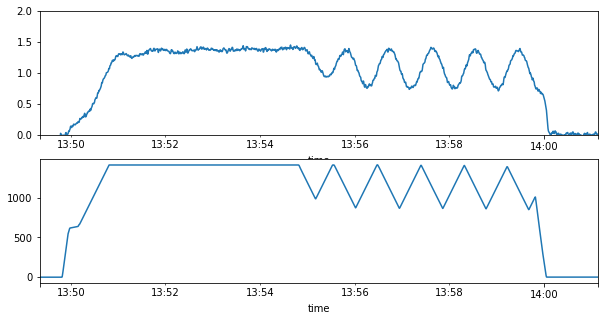

In [4]:
df = sb.resample_join('500ms',
                      bdata['depthFusion']['depth'],
                      bdata['pistonState']['position']
                     )

fig, ax = plt.subplots(2,1, figsize=(10,5))
df['depth'].plot(ylim=(0,2), ax=ax[0])
_ = df['position'].plot(ax=ax[1])

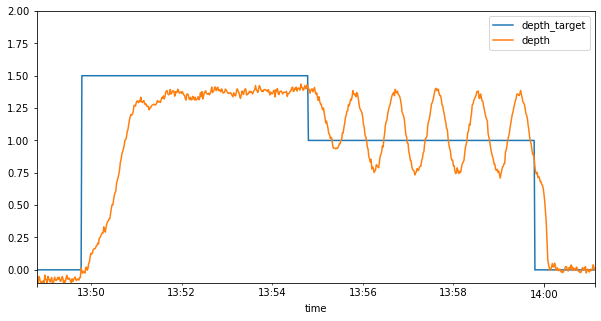

In [5]:
df_gen = sb.resample_join('1s',
                       bdata['mission']['depth'].rename('depth_target'),
                       bdata['depthFusion']['depth']
                      )
_ = df_gen.plot(ylim=(-.1, 2.), figsize=(10,5))

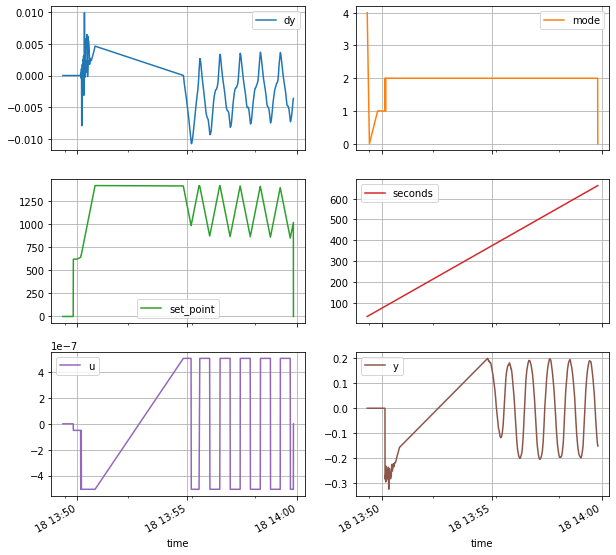

In [6]:
_ = bdata['regulation'].plot(subplots=True, grid=True, layout=(3,2),figsize=(10,10))

<bound method _AxesBase.grid of <matplotlib.axes._subplots.AxesSubplot object at 0x11b96b080>>

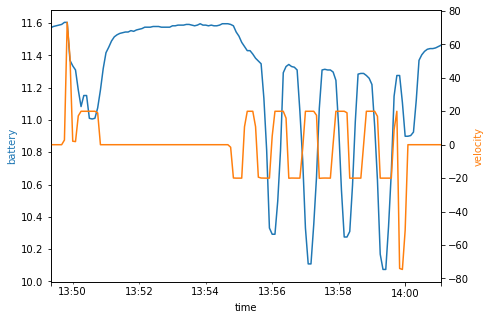

In [7]:
_df = sb.resample_join('5s',
                       bdata['batteryFusion']['b1'].rename('battery'),
                       bdata['pistonVelocity']['velocity'],
                       bdata['pistonState']['position']
                      )

fig, ax = plt.subplots(1,1, figsize=(7,5))

k0 = 'battery'
k1 = 'velocity'

_df[k0].plot(ax=ax, color='C0')
_ax = ax.twinx()
_df[k1].plot(ax=_ax, color='C1')
ax.set_ylabel(k0, color='C0')
_ax.set_ylabel(k1, color='C1')
ax.grid
#ax.legend()
#plt.show()

---
## kalman filter

In [8]:
kalman_state = (bdata['kalman'][[c for c in bdata['kalman'].columns if 'cov' not in c]]
                .drop(columns='seconds')
               )
kalman_cov = bdata['kalman'][[c for c in bdata['kalman'].columns if 'cov' in c]]

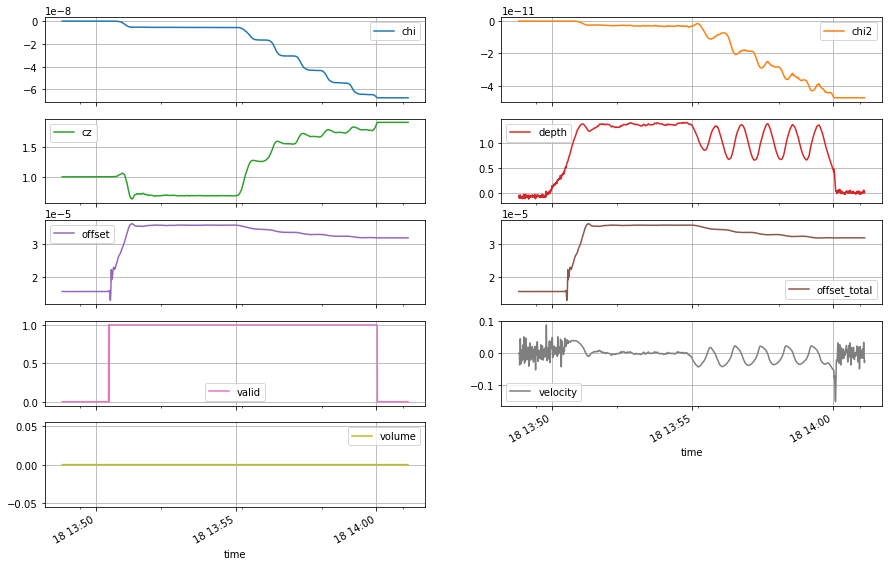

In [9]:
_ = kalman_state.plot(subplots=True, grid=True, layout=(5,2), figsize=(15,10))

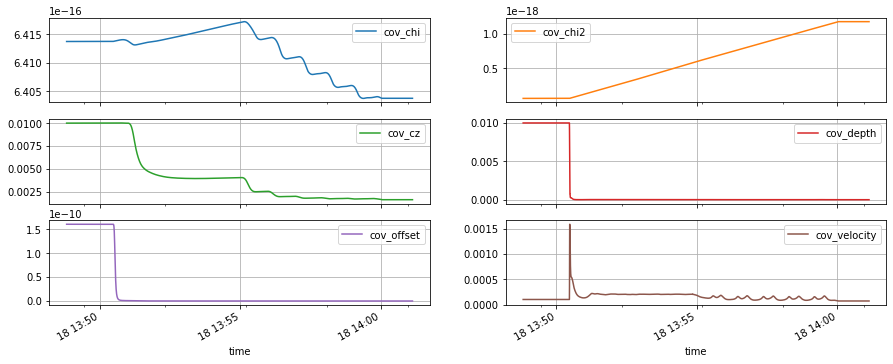

In [10]:
_ = kalman_cov.plot(subplots=True, grid=True, layout=(5,2), figsize=(15,10))

---

## instantiate float object

In [11]:
ph = cfg['physics']
f = fl.autonomous_float(model='Ifremer', m=ph['m'])
f.init_piston()

print('tick_to_volume = {:.2e}'.format(f.piston.vol_increment))
print('volume available = {:.2e}'.format(f.piston.vol_max-f.piston.vol_min))
print('balast volume = {:.2e}'.format(f.piston.vol_increment*619.25))

Piston max volume set from max displacement
tick_to_volume = 2.56e-08
volume available = 2.69e-05
balast volume = 1.59e-05


### stratification profile

Equivalent mass difference between z=0.0 and z=-1.8 because of water density only: -33.19587004069186g
Provided water profile at lon=6, lat=40


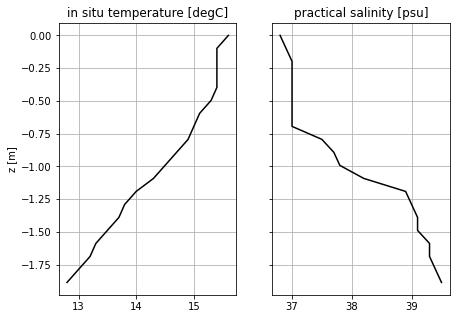

In [12]:
if True:
    cast = pd.read_csv(root_dir+'profil.csv', names=['depth', 'salinity', 'temperature'], skiprows=2)
    cast['depth'] = cast['depth']/1e2
    #cast['salinity'] = 37 # sans sel
    #cast['temperature'] = 14 # sans température
    w = fl.waterp(pressure=cast['depth'], temperature=cast['temperature'], salinity=cast['salinity'], lon=6.,lat=40.)

    _z = [0., -1.8]
    dm = (w.get_rho(0.)-w.get_rho(-1.8))*f.V
    print('Equivalent mass difference between z={} and z={} because of water density only: {}g'
         .format(_z[0],_z[1], dm*1e3))
    print(w)

In [13]:
p = np.arange(0,2,.1)
t = 15.*(p-p[-1])/(p[0]-p[-1]) - 16.*(p-p[0])/(p[0]-p[-1])
s = t*0.+30
w = fl.waterp(pressure=p, temperature=t, salinity=s, lon=6.,lat=40.) # 

Provided water profile at lon=6, lat=40

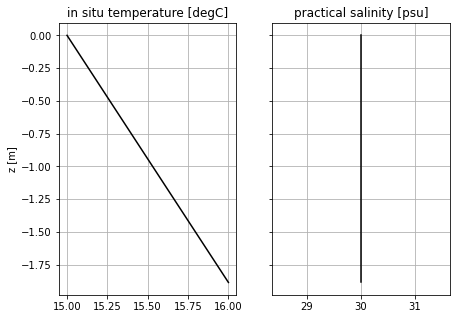

In [14]:
w

-444.0 g  were added to the float in order to be at equilibrium at 0 dbar 



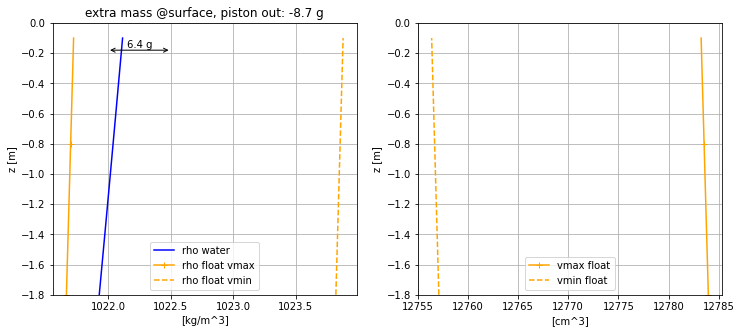

In [15]:
z=np.arange(-1.8,0.,.1)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

In [16]:
_z = [0., -1.8]
dm = (w.get_rho(0.)-w.get_rho(-1.8))*f.V
print('Equivalent mass difference between z={} and z={} because of water density only: {}g'
     .format(_z[0],_z[1], dm*1e3))

Equivalent mass difference between z=0.0 and z=-1.8 because of water density only: 2.511287559959642g


In [17]:
_z = [0., -1.8]
dm = (w.get_rho(0.)-w.get_rho(-1.8))*f.V
print('Equivalent mass difference between z={} and z={} because of water density only: {}g'
     .format(_z[0],_z[1], dm*1e3))

Equivalent mass difference between z=0.0 and z=-1.8 because of water density only: 2.511287559959642g


### extract stratification

Sampling rate: 0.20s


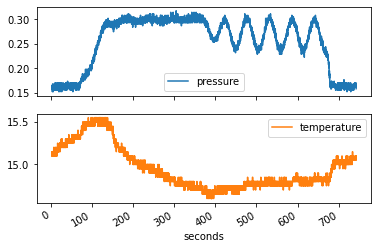

In [18]:
dt = bdata['sensorExt']['seconds'].diff()
print('Sampling rate: {:.2f}s'.format(dt[dt>0].mean()))
_ = bdata['sensorExt'][dt>0].plot(x='seconds', subplots=True)

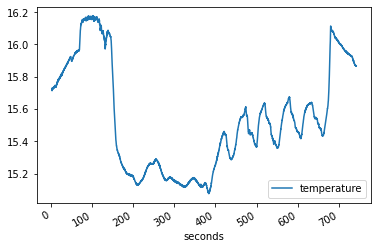

In [19]:
dv = abs(bdata['temperature']['temperature'].diff())
threshold = dv.quantile(.99)
_ = bdata['temperature'][dv<threshold].plot(x='seconds', subplots=True)

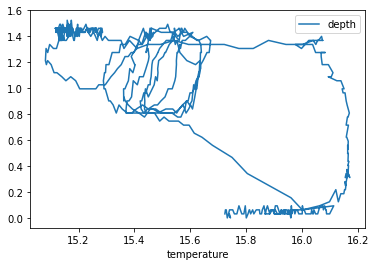

In [20]:
# merge pressure and temperature data

dv = abs(bdata['temperature']['temperature'].diff())
T = (bdata['temperature'][dv<threshold]['temperature']
     .resample('1s')
     .median()
    )

dt = bdata['sensorExt']['seconds'].diff()
D = (bdata['sensorExt'][dt>0]['pressure']
     .resample('1s')
     .median()
     .rename('depth')
     *1e5/(1000*9.81)
    )
D = D - D.min()

df = pd.concat([T, D], axis=1)

df.plot(x='temperature')

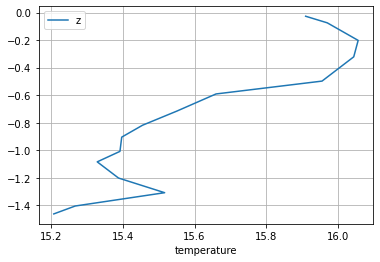

In [21]:
pr = sb.get_depth_profile(df)
pr.reset_index().plot(x='temperature', y='z', grid=True)